In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt



import nltk
import string
from wordcloud import WordCloud

from nltk.tokenize import RegexpTokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from mlxtend.plotting import plot_confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv
/kaggle/input/tmdb-movies-dataset/tmdb_movies_data.csv


## Import Data

In [14]:
movie_df = pd.read_csv('../input/tmdb-movies-dataset/tmdb_movies_data.csv')
wiki_df = pd.read_csv('../input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv')

movie_df.columns = movie_df.columns.str.lower()
wiki_df.columns = wiki_df.columns.str.lower()

## PreProcessing

In [15]:
movie_df['original_title'] = movie_df['original_title'].str.lower()
wiki_df['title'] = wiki_df['title'].str.lower()
cols_to_use = movie_df.columns.difference(wiki_df.columns)

wiki_df['plot'] = wiki_df['plot'].str.lower()

In [16]:
df = pd.merge(wiki_df, movie_df[cols_to_use],  how='inner', left_on=['title','release year'], right_on=['original_title','release_year'])
df.drop_duplicates(inplace=True)

In [17]:
df.head(2)

,release year,title,origin/ethnicity,director,cast,genre,wiki page,plot,budget,budget_adj,...,popularity,production_companies,release_date,release_year,revenue,revenue_adj,runtime,tagline,vote_average,vote_count
0,1960,13 ghosts,American,William Castle,"Charles Herbert, Jo Morrow",unknown,https://en.wikipedia.org/wiki/13_Ghosts,when occultist uncle dr. plato zorba wills a h...,0,0.0,...,0.110511,Columbia Pictures|William Castle Productions,8/5/1960,1960,0,0.0,85,IT'S FUN TO BE SCARED BY 13 GHOSTS,5.5,12
1,1960,the alamo,American,John Wayne,"John Wayne, Richard Widmark, Laurence Harvey, ...",unknown,https://en.wikipedia.org/wiki/The_Alamo_(1960_...,the film depicts the battle of the alamo and t...,0,0.0,...,0.310398,United Artists|Batjac Productions|The Alamo Co...,10/24/1960,1960,0,0.0,167,The Mission That Became a Fortress! The Fortre...,6.2,27


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6056 entries, 0 to 6055
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   release year          6056 non-null   int64  
 1   title                 6056 non-null   object 
 2   origin/ethnicity      6056 non-null   object 
 3   director              6056 non-null   object 
 4   cast                  6016 non-null   object 
 5   genre                 6056 non-null   object 
 6   wiki page             6056 non-null   object 
 7   plot                  6056 non-null   object 
 8   budget                6056 non-null   int64  
 9   budget_adj            6056 non-null   float64
 10  genres                6056 non-null   object 
 11  homepage              1506 non-null   object 
 12  id                    6056 non-null   int64  
 13  imdb_id               6056 non-null   object 
 14  keywords              5667 non-null   object 
 15  original_title       

In [19]:
df['genre'].value_counts()[:10]

comedy             1048
drama               866
horror              431
unknown             409
thriller            284
action              274
crime drama         204
science fiction     183
romantic comedy     123
fantasy              86
Name: genre, dtype: int64

In [ ]:
#Make new binning columns
for a,b in df.iterrows():
    if b['genre'] == 'comedy' or b['genre'] == 'Comedy':
        df.at[a, 'genre_new'] = 1
        df.at[a, 'genre_cat'] = 'Comedy'
    elif b['genre'] == 'drama' or b['genre'] == 'Drama':
        df.at[a, 'genre_new'] = 2
        df.at[a, 'genre_cat'] = 'Drama'
    elif b['genre'] == 'horror' or b['genre'] == 'Horror':
        df.at[a, 'genre_new'] = 3
        df.at[a, 'genre_cat'] = 'Horror'
    elif b['genre'] == 'thriller' or b['genre'] == 'Thriller':
        df.at[a, 'genre_new'] = 4
        df.at[a, 'genre_cat'] = 'Thriller'
    elif b['genre'] == 'action' or b['genre'] == 'Action':
        df.at[a, 'genre_new'] = 5
        df.at[a, 'genre_cat'] = 'Action'
    elif b['genre'] == 'adventure' or b['genre'] == 'Adventure':
        df.at[a, 'genre_new'] = 6
        df.at[a, 'genre_cat'] = 'Adventure'
    else:
        df.at[a, 'genre_new'] = 0
        df.at[a, 'genre_cat'] = 'Other'

In [21]:
df['genre_cat'].value_counts()[:10]

Other        3075
Comedy       1048
Drama         866
Horror        431
Thriller      284
Action        274
Adventure      78
Name: genre_cat, dtype: int64

# EDA

## Univariate Analysis

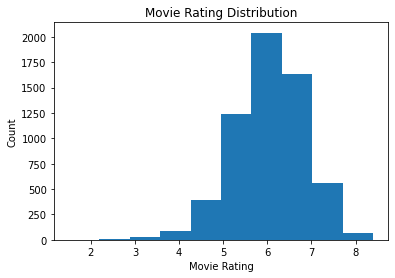

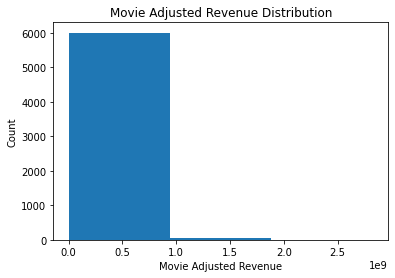

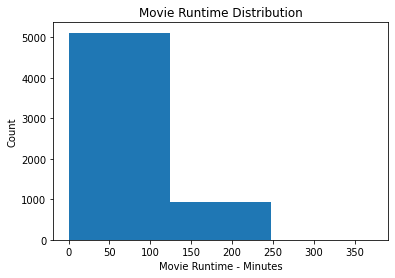

In [22]:
#Movie Rating Distribution
plt.hist(df.vote_average)
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.title('Movie Rating Distribution')
plt.show()

#Movie Adjusted Revenue Distribution
plt.hist(df.revenue_adj,bins = 3)
plt.xlabel('Movie Adjusted Revenue')
plt.ylabel('Count')
plt.title('Movie Adjusted Revenue Distribution')
plt.show()

#Movie Adjusted Revenue Distribution
plt.hist(df.runtime,bins = 3)
plt.xlabel('Movie Runtime - Minutes')
plt.ylabel('Count')
plt.title('Movie Runtime Distribution')
plt.show()

## Bivariate Analysis

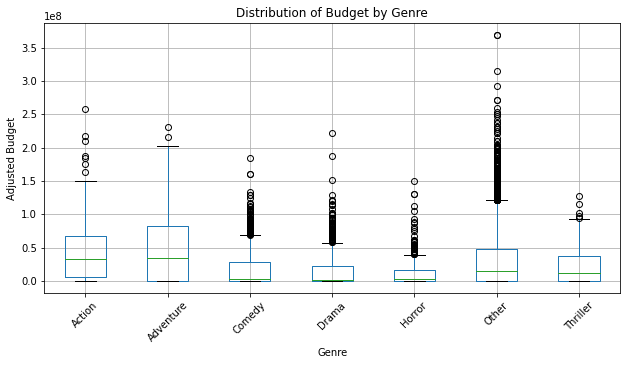

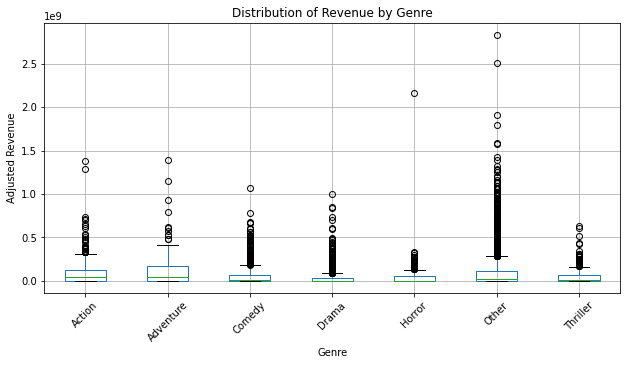

In [23]:
#Create Box Plot
fig1 = df.boxplot(column=['budget_adj'],by ='genre_cat', rot = 45, figsize = (10,5))
#Create Title
plt.title('Distribution of Budget by Genre')
plt.suptitle('')
plt.ylabel('Adjusted Budget')
plt.xlabel('Genre')
#Show Plot
plt.show()

#Create Box Plot
fig1 = df.boxplot(column=['revenue_adj'],by ='genre_cat', rot = 45, figsize = (10,5))
#Create Title
plt.title('Distribution of Revenue by Genre')
plt.suptitle('')
plt.ylabel('Adjusted Revenue')
plt.xlabel('Genre')
#Show Plot
plt.show()

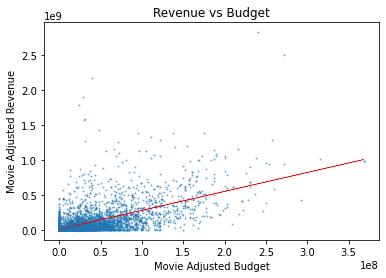

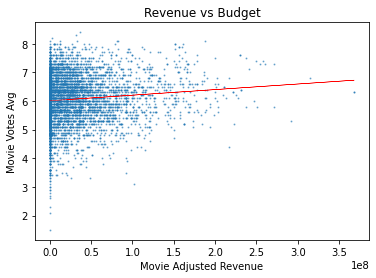

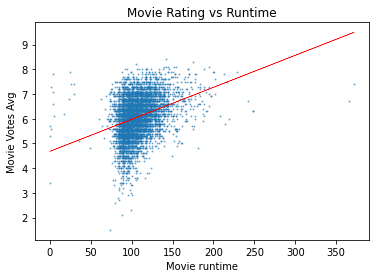

In [24]:
#Movie vs Revenue - Postive Relationship
plt.plot(df.budget_adj, df.revenue_adj, 'o', markersize =1, alpha = 0.5)
m, b = np.polyfit(df.budget_adj, df.revenue_adj, 1)
plt.plot(df.budget_adj, m*df.budget_adj + b, 'red', linewidth = 0.5)
plt.xlabel('Movie Adjusted Budget')
plt.ylabel('Movie Adjusted Revenue')
plt.title('Revenue vs Budget')
plt.show()

#Movie vs Revenue - Weak Relationship
plt.plot(df.budget_adj, df.vote_average, 'o', markersize =1, alpha = 0.5)
m, b = np.polyfit(df.budget_adj, df.vote_average, 1)
plt.plot(df.budget_adj, m*df.budget_adj + b, 'red', linewidth = 0.5)
plt.xlabel('Movie Adjusted Revenue')
plt.ylabel('Movie Votes Avg')
plt.title('Revenue vs Budget')
plt.show()

#Movie vs Revenue - Outliers Contribute
plt.plot(df.runtime, df.vote_average, 'o', markersize =1, alpha = 0.5)
m, b = np.polyfit(df.runtime, df.vote_average, 1)
plt.plot(df.runtime, m*df.runtime + b, 'red', linewidth = 0.5)
plt.xlabel('Movie runtime')
plt.ylabel('Movie Votes Avg')
plt.title('Movie Rating vs Runtime')
plt.show()

## Text Analysis

In [25]:
#String for WordCloud
list123 = ''
#Iterate through training values
for a in wiki_df['plot']:
    list123 += a

In [26]:
nltk.download("stopwords")
nltk.download("punkt")
#Create Stop Words Corpus
stop_words = nltk.corpus.stopwords.words("english") + list(string.punctuation) \
+ list(string.ascii_lowercase) + list(string.ascii_uppercase) + list(string.digits) \
+ list(['--']+["''"]+["``"]+[".."]+["..."]+["ii"]+["iii"]+["iv"]+["'s"]+["the"]+["however"] \
+ ["when"]+["as"]+["meanwhile"]+['eventually'])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
#Tokenize Words
HR1_token = nltk.word_tokenize(list123)
#Remove Stops words
hr1_filter = [w for w in HR1_token if not w in stop_words]
#Count Words
hr1_counter = Counter(hr1_filter)
#Sort Words by counts
sorted_word_counts = sorted(list(hr1_counter.values()), reverse=True)

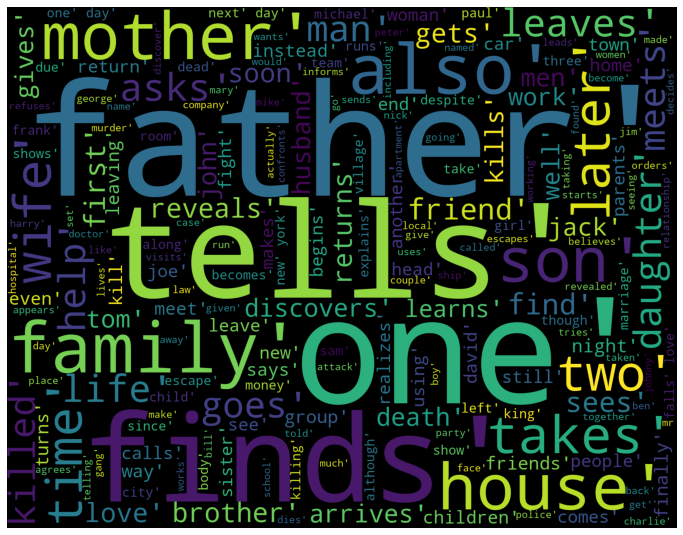

In [28]:
#Set Width & Height
width = 12
height = 12
#Initialize Plot
plt.figure(figsize=(width, height))
#Generate Wordplot
wordcloud = WordCloud(width=1800,height=1400).generate(str(hr1_filter))
#Show Plot
plt.imshow(wordcloud)
plt.axis("off")
#Generate Plot
plt.show()

# Predictive Models

In [32]:
#New DF with orginal Wiki Data
df2aa = wiki_df
#Make new binning columns
for a,b in df2aa.iterrows():
    if b['genre'] == 'comedy' or b['genre'] == 'Comedy':
        df2aa.at[a, 'genre_new'] = 1
        df2aa.at[a, 'genre_cat'] = 'Comedy'
    elif b['genre'] == 'drama' or b['genre'] == 'Drama':
        df2aa.at[a, 'genre_new'] = 2
        df2aa.at[a, 'genre_cat'] = 'Drama'
    elif b['genre'] == 'horror' or b['genre'] == 'Horror':
        df2aa.at[a, 'genre_new'] = 3
        df2aa.at[a, 'genre_cat'] = 'Horror'
    elif b['genre'] == 'thriller' or b['genre'] == 'Thriller':
        df2aa.at[a, 'genre_new'] = 4
        df2aa.at[a, 'genre_cat'] = 'Thriller'
    elif b['genre'] == 'action' or b['genre'] == 'Action':
        df2aa.at[a, 'genre_new'] = 5
        df2aa.at[a, 'genre_cat'] = 'Action'
    elif b['genre'] == 'adventure' or b['genre'] == 'Adventure':
        df2aa.at[a, 'genre_new'] = 6
        df2aa.at[a, 'genre_cat'] = 'Adventure'
    else:
        df2aa.at[a, 'genre_new'] = 0
        df2aa.at[a, 'genre_cat'] = 'Other'
#Make new binning columns
for a,b in df2aa.iterrows():
    if b['genre'] == 'comedy' or b['genre'] == 'Comedy':
        df2aa.at[a, 'Comedy'] = 1
    else:
        df2aa.at[a, 'Comedy'] = 0
#Assign X-Data
X3 = df2aa['plot']
#Assign Target Data
y3 = df2aa['genre_new']
y2 = df2aa['Comedy']

## Predict if movie plot is comedy of not

## Naives Bayes Model

In [89]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X3, y2 , test_size = 0.33, random_state = 53)
# Create and fit & Transform the Vectorizer
count_vectorizer2 = CountVectorizer(stop_words = 'english')
count_train3 = count_vectorizer2.fit_transform(X_train.values) 
count_test3 = count_vectorizer2.transform(X_test.values)

In [90]:
# Create and fit the model
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train3, y_train)
# Predict on the test features, print the results
pred1 = nb_classifier.predict(count_test3)
# Print the accuracy
metrics.accuracy_score(y_test, pred1)

0.8522539737687831

In [91]:
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, pred1))
print("\n\n Classification Report:\n")
print(metrics.classification_report(y_test, pred1))

Confusion Matrix:
[[9111  960]
 [ 741  701]]


 Classification Report:

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91     10071
         1.0       0.42      0.49      0.45      1442

    accuracy                           0.85     11513
   macro avg       0.67      0.70      0.68     11513
weighted avg       0.86      0.85      0.86     11513



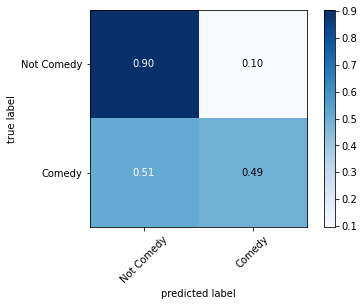

In [92]:
classes = ['Not Comedy', 'Comedy']
cm = metrics.confusion_matrix(y_test, pred1)

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

## Predict if movie plot is Comedy, Drama, Horror, Thriller, Action, Adventure, or other.

## Regression Model

In [93]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X3, y3 , test_size = 0.33, random_state = 53)
# Create and fit & Transform the Vectorizer
count_vectorizer2 = CountVectorizer(stop_words = 'english')
count_train3 = count_vectorizer2.fit_transform(X_train.values) 
count_test3 = count_vectorizer2.transform(X_test.values)

In [94]:
# Create and fit the model
linreg = LinearRegression().fit(count_train3,y_train)
# Predict on the test features, print the results
pred3 = linreg.predict(count_test3)

# The mean squared error
print('Mean squared error: %.4f'
      % metrics.mean_squared_error(pred3,y_test))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'
      % metrics.r2_score(pred3, y_test))

Mean squared error: 19.6508
Coefficient of determination: -0.0672


## Naives Bayes Model

In [95]:
# Create and fit the model
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train3, y_train)
# Predict on the test features, print the results
pred2 = nb_classifier.predict(count_test3)
metrics.accuracy_score(y_test, pred2)

0.5969773299748111

In [96]:
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, pred2))
print("\n\n Classification Report:\n")
print(metrics.classification_report(y_test, pred2))

Confusion Matrix:
[[5051  694  949   95    6   58   11]
 [ 456  712  268    4    0    2    0]
 [ 829  228  908    7    1    3    4]
 [ 166    8   29  166    0    0    0]
 [ 217   28   67   20    1    3    0]
 [ 294   13   12    0    0   23    0]
 [ 142    5   21    0    0    0   12]]


 Classification Report:

              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72      6864
         1.0       0.42      0.49      0.45      1442
         2.0       0.40      0.46      0.43      1980
         3.0       0.57      0.45      0.50       369
         4.0       0.12      0.00      0.01       336
         5.0       0.26      0.07      0.11       342
         6.0       0.44      0.07      0.12       180

    accuracy                           0.60     11513
   macro avg       0.42      0.32      0.33     11513
weighted avg       0.58      0.60      0.58     11513



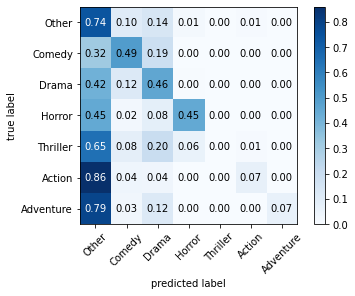

In [97]:
classes = ['Other','Comedy','Drama','Horror','Thriller','Action','Adventure']
cm = metrics.confusion_matrix(y_test, pred2)

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()